In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np




def tradeBracket(price,entryBar,upper=None, lower=None, timeout=None):
    '''
    trade a  bracket on price series, return price delta and exit bar #
    Input
    ------
        price : numpy array of price values
        entryBar: entry bar number, *determines entry price*
        upper : high stop
        lower : low stop
        timeout : max number of periods to hold
    Returns exit price  and number of bars held
    '''
    assert isinstance(price, np.ndarray) , 'price must be a numpy array'
    
    
    # create list of exit indices and add max trade duration. Exits are relative to entry bar
    if timeout: # set trade length to timeout or series length
        exits = [min(timeout,len(price)-entryBar-1)]
    else:
        exits = [len(price)-entryBar-1] 
        
    p = price[entryBar:entryBar+exits[0]+1] # subseries of price
    
    # extend exits list with conditional exits
    # check upper bracket
    if upper:
        assert upper>p[0] , 'Upper bracket must be higher than entry price '
        idx = np.where(p>upper)[0] # find where price is higher than the upper bracket
        if idx.any(): 
            exits.append(idx[0]) # append first occurence
    # same for lower bracket
    if lower:
        assert lower<p[0] , 'Lower bracket must be lower than entry price '
        idx = np.where(p<lower)[0]
        if idx.any(): 
            exits.append(idx[0]) 
   
    
    exitBar = min(exits) # choose first exit    
  
    

    return p[exitBar], exitBar


class Backtest(object):
    """
    Backtest class, simple vectorized one. Works with pandas objects.
    """
    
    def __init__(self,price, signal, signalType='capital',initialCash = 0, roundShares=True):
        """
        Arguments:
        
        *price*  Series with instrument price.
        *signal* Series with capital to invest (long+,short-) or number of shares. 
        *sitnalType* capital to bet or number of shares 'capital' mode is default.
        *initialCash* starting cash. 
        *roundShares* round off number of shares to integers
        
        """
        
        #TODO: add auto rebalancing
        
        # check for correct input
        assert signalType in ['capital','shares'], "Wrong signal type provided, must be 'capital' or 'shares'"
        
        #save internal settings to a dict
        self.settings = {'signalType':signalType}
        
        # first thing to do is to clean up the signal, removing nans and duplicate entries or exits
        self.signal = signal.ffill().fillna(0)
        
        # now find dates with a trade
        tradeIdx = self.signal.diff().fillna(0) !=0 # days with trades are set to True
        if signalType == 'shares':
            self.trades = self.signal[tradeIdx] # selected rows where tradeDir changes value. trades are in Shares
        elif signalType =='capital':
            self.trades = (self.signal[tradeIdx]/price[tradeIdx])
            if roundShares:
                self.trades = self.trades.round()
        
        # now create internal data structure 
        self.data = pd.DataFrame(index=price.index , columns = ['price','shares','value','cash','pnl'])
        self.data['price'] = price
        
        self.data['shares'] = self.trades.reindex(self.data.index).ffill().fillna(0)
        self.data['value'] = self.data['shares'] * self.data['price']
       
        delta = self.data['shares'].diff() # shares bought sold
        
        self.data['cash'] = (-delta*self.data['price']).fillna(0).cumsum()+initialCash
        self.data['pnl'] = self.data['cash']+self.data['value']-initialCash
      
      
    @property
    def sharpe(self):
        ''' return annualized sharpe ratio of the pnl '''
        pnl = (self.data['pnl'].diff()).shift(-1)[self.data['shares']!=0] # use only days with position.
        return sharpe(pnl)  # need the diff here as sharpe works on daily returns.
        
    @property
    def pnl(self):
        '''easy access to pnl data column '''
        return self.data['pnl']
    
    def plotTrades(self):
        """ 
        visualise trades on the price chart 
            long entry : green triangle up
            short entry : red triangle down
            exit : black circle
        """
        l = ['price']
        
        p = self.data['price']
        p.plot(style='x-')
        
        # ---plot markers
        # this works, but I rather prefer colored markers for each day of position rather than entry-exit signals
#         indices = {'g^': self.trades[self.trades > 0].index , 
#                    'ko':self.trades[self.trades == 0].index, 
#                    'rv':self.trades[self.trades < 0].index}
#        
#         
#         for style, idx in indices.iteritems():
#             if len(idx) > 0:
#                 p[idx].plot(style=style)
        
        # --- plot trades
        #colored line for long positions
        idx = (self.data['shares'] > 0) | (self.data['shares'] > 0).shift(1) 
        if idx.any():
            p[idx].plot(style='go')
            l.append('long')
        
        #colored line for short positions    
        idx = (self.data['shares'] < 0) | (self.data['shares'] < 0).shift(1) 
        if idx.any():
            p[idx].plot(style='ro')
            l.append('short')

        plt.xlim([p.index[0],p.index[-1]]) # show full axis
        
        plt.legend(l,loc='best')
        plt.title('trades')
        
        
class ProgressBar:
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 50
        self.__update_amount(0)

    def animate(self, iteration):
        sys.stdout.flush()
        self.update_iteration(iteration + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])
    def __str__(self):
        return str(self.prog_bar)
    
def sharpe(pnl):
    return  np.sqrt(250)*pnl.mean()/pnl.std()

<ipython-input-39-221031e9b1b6>:153: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  signal = pd.Series(index=np.arange(len(indata)))


qval
[[ 0.7453   1.22049  0.06998 -0.85694]]
qval
[[ 0.04491  0.0224   0.17375 -0.13012]]
qval
[[ 0.03946  0.01968  0.15123 -0.11434]]
qval
[[ 0.03504  0.01747  0.1331  -0.10151]]
qval
[[ 0.03768  0.01689  0.12868 -0.09811]]
qval
[[ 0.03318  0.01469  0.11209 -0.08535]]
qval
[[ 0.02868  0.01249  0.09551 -0.07259]]
qval
[[ 0.0242   0.0103   0.0777  -0.05984]]
qval
[[ 0.0199   0.01168  0.06186 -0.04763]]
qval
[[ 0.01464  0.009    0.03906 -0.03266]]
qval
[[ 0.00975  0.00652  0.02114 -0.01548]]
qval
[[-0.01808 -0.00305  0.00066 -0.05756]]
qval
[[-0.02089  0.01844 -0.01203 -0.13119]]
qval
[[-0.03422  0.02766 -0.01509 -0.21311]]
qval
[[-0.04842  0.03797 -0.01843 -0.29413]]
qval
[[-0.06745  0.04432 -0.03278 -0.37659]]
qval
[[-0.07942  0.06112 -0.03531 -0.45753]]
qval
[[-0.10465  0.06828 -0.04419 -0.54353]]
qval
[[-0.12019  0.07749 -0.04904 -0.62516]]


<ipython-input-39-221031e9b1b6>:100: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  signal = pd.Series(index=np.arange(len(eval_data)))


Epoch #: 0 Reward: -52.026598 Epsilon: 1.000000
qval
[[ 0.74544  1.24316  0.07306 -0.86025]]
qval
[[ 0.04262  0.02767  0.14635 -0.11187]]
qval
[[ 0.03784  0.02513  0.12874 -0.09518]]
qval
[[ 0.0349   0.02357  0.11789 -0.08686]]
qval
[[ 0.03075  0.02137  0.0996  -0.07512]]
qval
[[ 0.02697  0.01936  0.08572 -0.06443]]
qval
[[ 0.02192  0.01668  0.06717 -0.04703]]
qval
[[ 0.01788  0.01454  0.05233 -0.03568]]
qval
[[ 0.01383  0.01239  0.03748 -0.02432]]
qval
[[ 0.00979  0.01025  0.02263 -0.01295]]
qval
[[0.00526 0.00785 0.00601 0.00213]]
qval
[[-0.02005 -0.00049 -0.01212 -0.03663]]
qval
[[-0.02741  0.02468 -0.02663 -0.12336]]
qval
[[-0.04499  0.03405 -0.03213 -0.21473]]
qval
[[-0.06071  0.04336 -0.037   -0.29784]]
qval
[[-0.08527  0.0508  -0.04524 -0.38394]]
qval
[[-0.10193  0.05992 -0.05053 -0.46736]]
qval
[[-0.11573  0.06856 -0.05625 -0.53222]]
qval
[[-0.13216  0.07763 -0.06162 -0.61399]]


<ipython-input-39-221031e9b1b6>:100: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  signal = pd.Series(index=np.arange(len(eval_data)))


Epoch #: 1 Reward: -17.342199 Epsilon: 0.900000
qval
[[ 0.72372  1.22546  0.06849 -0.83358]]
qval
[[ 0.03392  0.02761  0.12174 -0.08509]]
qval
[[ 0.03125  0.02616  0.11182 -0.07754]]
qval
[[ 0.02857  0.02471  0.1019  -0.07   ]]
qval
[[ 0.0259   0.02326  0.09198 -0.06245]]
qval
[[ 0.02094  0.02056  0.07353 -0.0452 ]]
qval
[[ 0.01707  0.01848  0.05927 -0.03442]]
qval
[[ 0.0132   0.01639  0.04501 -0.02364]]
qval
[[ 0.00937  0.01431  0.03076 -0.01286]]
qval
[[ 0.00553  0.01222  0.0165  -0.00209]]
qval
[[0.00177 0.01331 0.00254 0.00846]]
qval
[[-0.02314  0.00522 -0.01509 -0.02971]]
qval
[[-0.03407  0.02615 -0.0316  -0.11926]]
qval
[[-0.05896  0.03356 -0.04039 -0.20419]]
qval
[[-0.07637  0.04254 -0.04629 -0.28612]]
qval
[[-0.09377  0.05152 -0.05219 -0.36801]]
qval
[[-0.10929  0.06036 -0.05833 -0.43929]]
qval
[[-0.12658  0.06931 -0.06431 -0.52008]]
qval
[[-0.14383  0.07828 -0.07026 -0.60096]]


<ipython-input-39-221031e9b1b6>:100: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  signal = pd.Series(index=np.arange(len(eval_data)))


Epoch #: 2 Reward: -17.342199 Epsilon: 0.800000
qval
[[ 0.70194  1.20521  0.06989 -0.80589]]
qval
[[ 0.02781  0.02976  0.11288 -0.07357]]
qval
[[ 0.02533  0.02835  0.10351 -0.0665 ]]
qval
[[ 0.02335  0.03055  0.09603 -0.06086]]
qval
[[ 0.01848  0.02884  0.08506 -0.05259]]
qval
[[ 0.01529  0.02694  0.07281 -0.04335]]
qval
[[ 0.01157  0.02472  0.05851 -0.03256]]
qval
[[ 0.01141  0.02284  0.04639 -0.02342]]
qval
[[ 0.00757  0.02059  0.0319  -0.0125 ]]
qval
[[ 0.00373  0.01834  0.01739 -0.00156]]
qval
[[-0.00056  0.01583 -0.002    0.01066]]
qval
[[-0.02637  0.00917 -0.02046 -0.02814]]
qval
[[-0.03924  0.02858 -0.03773 -0.11625]]
qval
[[-0.05972  0.03593 -0.05254 -0.19839]]
qval
[[-0.0773   0.04458 -0.0597  -0.27924]]
qval
[[-0.09245  0.05284 -0.06672 -0.34522]]
qval
[[-0.10989  0.06142 -0.07393 -0.42457]]
qval
[[-0.12727  0.07002 -0.08112 -0.5039 ]]
qval
[[-0.14239  0.08685 -0.08665 -0.58321]]


<ipython-input-39-221031e9b1b6>:100: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  signal = pd.Series(index=np.arange(len(eval_data)))


Epoch #: 3 Reward: 52.026598 Epsilon: 0.700000
qval
[[ 0.70317  1.2176   0.05803 -0.79007]]
qval
[[ 0.02872  0.03713  0.10466 -0.06948]]
qval
[[ 0.0262   0.03561  0.09522 -0.06233]]
qval
[[ 0.02368  0.03409  0.08578 -0.05519]]
qval
[[ 0.02215  0.03656  0.08008 -0.05087]]
qval
[[ 0.01949  0.03491  0.07012 -0.04545]]
qval
[[ 0.01551  0.03244  0.05521 -0.03411]]
qval
[[ 0.01152  0.02997  0.0403  -0.02277]]
qval
[[ 0.00754  0.0275   0.02539 -0.01143]]
qval
[[ 0.00708  0.02531  0.01219 -0.00138]]
qval
[[ 0.00333  0.02303 -0.0016   0.00719]]
qval
[[-0.02071  0.01519 -0.02036 -0.02682]]
qval
[[-0.03558  0.03412 -0.04155 -0.1133 ]]
qval
[[-0.05587  0.04203 -0.0571  -0.19402]]
qval
[[-0.07326  0.05128 -0.06516 -0.27351]]
qval
[[-0.09065  0.06054 -0.07322 -0.353  ]]
qval
[[-0.10421  0.07846 -0.07757 -0.43213]]
qval
[[-0.12119  0.08856 -0.08521 -0.51156]]
qval
[[-0.14186  0.09877 -0.09288 -0.61093]]


<ipython-input-39-221031e9b1b6>:100: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  signal = pd.Series(index=np.arange(len(eval_data)))


Epoch #: 4 Reward: 52.026598 Epsilon: 0.600000
qval
[[ 0.69834  1.22082  0.04654 -0.79633]]
qval
[[ 0.03654  0.04656  0.11702 -0.08937]]
qval
[[ 0.0344   0.04667  0.10918 -0.08333]]
qval
[[ 0.02988  0.0438   0.09017 -0.07057]]
qval
[[ 0.02732  0.04354  0.08083 -0.06334]]
qval
[[ 0.0227   0.04057  0.06198 -0.05032]]
qval
[[ 0.01869  0.038    0.04742 -0.039  ]]
qval
[[ 0.01468  0.03542  0.03286 -0.02768]]
qval
[[ 0.01067  0.03284  0.01829 -0.01636]]
qval
[[ 0.007    0.03336  0.00495 -0.00598]]
qval
[[ 0.00295  0.03071 -0.00972  0.00542]]
qval
[[-0.026    0.02135 -0.03575 -0.03476]]
qval
[[-0.03888  0.04292 -0.05584 -0.12324]]
qval
[[-0.05615  0.05319 -0.06365 -0.20426]]
qval
[[-0.07343  0.06346 -0.07146 -0.28527]]
qval
[[-0.08718  0.08123 -0.07582 -0.36597]]
qval
[[-0.1065   0.09131 -0.09166 -0.44778]]
qval
[[-0.12234  0.10542 -0.09878 -0.52875]]
qval
[[-0.13937  0.1167  -0.10706 -0.60978]]


<ipython-input-39-221031e9b1b6>:100: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  signal = pd.Series(index=np.arange(len(eval_data)))


Epoch #: 5 Reward: 121.395396 Epsilon: 0.500000
qval
[[ 0.69044  1.22604  0.03078 -0.78258]]
qval
[[ 0.03417  0.05497  0.09885 -0.08269]]
qval
[[ 0.03144  0.05312  0.08898 -0.07498]]
qval
[[ 0.02871  0.05127  0.07912 -0.06728]]
qval
[[ 0.02436  0.04833  0.0604  -0.055  ]]
qval
[[ 0.02112  0.04614  0.04876 -0.04587]]
qval
[[ 0.01723  0.04351  0.03479 -0.0349 ]]
qval
[[ 0.01362  0.0435   0.0218  -0.0247 ]]
qval
[[ 0.00971  0.0408   0.00774 -0.01366]]
qval
[[ 0.0052   0.03769 -0.0108  -0.00094]]
qval
[[ 0.0014   0.03591 -0.02446  0.0098 ]]
qval
[[-0.02708  0.0272  -0.0453  -0.03316]]
qval
[[-0.04389  0.0512  -0.06689 -0.12611]]
qval
[[-0.06056  0.06453 -0.07479 -0.20746]]
qval
[[-0.07798  0.07605 -0.0833  -0.28874]]
qval
[[-0.09539  0.08757 -0.09181 -0.37001]]
qval
[[-0.11281  0.09908 -0.10032 -0.45128]]
qval
[[-0.13023  0.1106  -0.10883 -0.53255]]
qval
[[-0.14765  0.12212 -0.11734 -0.61382]]


<ipython-input-39-221031e9b1b6>:100: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  signal = pd.Series(index=np.arange(len(eval_data)))


Epoch #: 6 Reward: 156.079795 Epsilon: 0.400000
qval
[[ 0.69167  1.25109  0.02344 -0.80338]]
qval
[[ 0.02792  0.05785  0.08348 -0.07511]]
qval
[[ 0.02398  0.05507  0.06697 -0.06383]]
qval
[[ 0.0216   0.05339  0.05832 -0.05701]]
qval
[[ 0.01922  0.05171  0.04968 -0.05018]]
qval
[[ 0.01679  0.05304  0.04089 -0.04324]]
qval
[[ 0.01303  0.05032  0.02728 -0.03249]]
qval
[[ 0.00928  0.04761  0.01366 -0.02173]]
qval
[[ 0.00552  0.04489  0.00005 -0.01098]]
qval
[[ 0.00177  0.04217 -0.01357 -0.00022]]
qval
[[-0.00199  0.03946 -0.02718  0.01053]]
qval
[[-0.03555  0.02935 -0.05151 -0.04001]]
qval
[[-0.04314  0.05597 -0.06841 -0.12592]]
qval
[[-0.06052  0.06767 -0.07698 -0.20719]]
qval
[[-0.07791  0.07936 -0.08554 -0.28847]]
qval
[[-0.0953   0.09105 -0.0941  -0.36974]]
qval
[[-0.11269  0.10274 -0.10267 -0.45101]]
qval
[[-0.13008  0.11443 -0.11123 -0.53228]]
qval
[[-0.14747  0.12612 -0.1198  -0.61355]]


<ipython-input-39-221031e9b1b6>:100: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  signal = pd.Series(index=np.arange(len(eval_data)))


Epoch #: 7 Reward: 190.764193 Epsilon: 0.300000
qval
[[ 0.68886  1.24874  0.02184 -0.79831]]
qval
[[ 0.02713  0.06079  0.07838 -0.07285]]
qval
[[ 0.02293  0.05775  0.06005 -0.06082]]
qval
[[ 0.02064  0.05608  0.05179 -0.05427]]
qval
[[ 0.01696  0.05341  0.03851 -0.04017]]
qval
[[ 0.01454  0.05165  0.02977 -0.03328]]
qval
[[ 0.01099  0.04908  0.01695 -0.02318]]
qval
[[ 0.00743  0.0465   0.00413 -0.01308]]
qval
[[ 0.00388  0.04392 -0.00868 -0.00297]]
qval
[[ 0.00033  0.04134 -0.0215   0.00713]]
qval
[[-0.00323  0.03877 -0.03432  0.01723]]
qval
[[-0.03649  0.02892 -0.05778 -0.03385]]
qval
[[-0.04347  0.05636 -0.07371 -0.12034]]
qval
[[-0.06072  0.06836 -0.08224 -0.2015 ]]
qval
[[-0.07797  0.08037 -0.09076 -0.28265]]
qval
[[-0.09522  0.09237 -0.09928 -0.36381]]
qval
[[-0.11247  0.10438 -0.10781 -0.44497]]
qval
[[-0.12972  0.11638 -0.11633 -0.52613]]
qval
[[-0.14697  0.12839 -0.12486 -0.60729]]


<ipython-input-39-221031e9b1b6>:100: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  signal = pd.Series(index=np.arange(len(eval_data)))


Epoch #: 8 Reward: 260.132991 Epsilon: 0.200000
qval
[[ 0.68384  1.24091  0.02001 -0.78383]]
qval
[[ 0.02348  0.05891  0.06203 -0.05871]]
qval
[[ 0.01963  0.05609  0.04482 -0.04775]]
qval
[[ 0.0179   0.05797  0.03863 -0.04285]]
qval
[[ 0.01584  0.05643  0.03124 -0.03699]]
qval
[[ 0.01366  0.05479  0.02339 -0.03078]]
qval
[[ 0.01019  0.05219  0.01093 -0.02091]]
qval
[[ 0.00671  0.04959 -0.00153 -0.01103]]
qval
[[ 0.00324  0.04699 -0.014   -0.00116]]
qval
[[-0.00023  0.04438 -0.02646  0.00871]]
qval
[[-0.00326  0.04211 -0.03732  0.01732]]
qval
[[-0.0365   0.03244 -0.06169 -0.03278]]
qval
[[-0.04259  0.06128 -0.07679 -0.11948]]
qval
[[-0.05952  0.07403 -0.08507 -0.20064]]
qval
[[-0.07645  0.08678 -0.09334 -0.2818 ]]
qval
[[-0.09338  0.09953 -0.10162 -0.36295]]
qval
[[-0.11031  0.11228 -0.10989 -0.44411]]
qval
[[-0.12724  0.12503 -0.11817 -0.52527]]
qval
[[-0.14417  0.13779 -0.12644 -0.60642]]


<ipython-input-39-221031e9b1b6>:100: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  signal = pd.Series(index=np.arange(len(eval_data)))


Epoch #: 9 Reward: 294.817390 Epsilon: 0.100000
Completed in 19.200000
       price  shares       value        cash         pnl  delta
0  -1.647509     0.0   -0.000000    0.000000    0.000000    0.0
1  -1.474087     0.0   -0.000000    0.000000    0.000000    0.0
2  -1.300665   100.0 -130.066495  130.066495    0.000000  100.0
3  -1.127243  -100.0  112.724296  -95.382097   17.342199 -200.0
4  -0.953821   100.0  -95.382097   95.382097    0.000000  200.0
5  -0.780399   100.0  -78.039897   95.382097   17.342199    0.0
6  -0.606977   100.0  -60.697698   95.382097   34.684399    0.0
7  -0.433555   100.0  -43.355498   95.382097   52.026598    0.0
8  -0.260133   100.0  -26.013299   95.382097   69.368798    0.0
9  -0.086711   100.0   -8.671100   95.382097   86.710997    0.0
10  0.086711   100.0    8.671100   95.382097  104.053196    0.0
11  0.260133   100.0   26.013299   95.382097  121.395396    0.0
12  0.433555   100.0   43.355498   95.382097  138.737595    0.0
13  0.606977   100.0   60.697698 

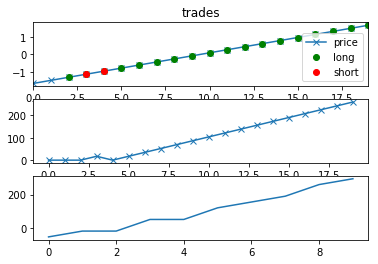

In [39]:
from __future__ import print_function

import numpy as np
np.random.seed(1335)  # for reproducibility
np.set_printoptions(precision=5, suppress=True, linewidth=150)

import pandas as pd
from matplotlib import pyplot as plt

from sklearn import metrics, preprocessing

'''
Name:        The Self Learning Quant, Example 1
Author:      Daniel Zakrisson
Created:     30/03/2016
Copyright:   (c) Daniel Zakrisson 2016
Licence:     BSD
Requirements:
Numpy
Pandas
MatplotLib
scikit-learn
Keras, https://keras.io/
backtest.py from the TWP library. Download backtest.py and put in the same folder
/plt create a subfolder in the same directory where plot files will be saved
'''

#Load data
def load_data():
    price = np.arange(200/10.0) #linearly increasing prices
    return price

#Initialize first state, all items are placed deterministically
def init_state(data):
    
    close = data
    diff = np.diff(data)
    diff = np.insert(diff, 0, 0)
    #--- Preprocess data
    xdata = np.column_stack((close, diff))
    xdata = np.nan_to_num(xdata)
    scaler = preprocessing.StandardScaler()
    xdata = scaler.fit_transform(xdata)
    state = xdata[0:1, :]
    return state, xdata

#Take Action
def take_action(state, xdata, action, signal, time_step):
    #this should generate a list of trade signals that at evaluation time are fed to the backtester
    #the backtester should get a list of trade signals and a list of price data for the assett
    
    #make necessary adjustments to state and then return it
    time_step += 1
    
    #if the current iteration is the last state ("terminal state") then set terminal_state to 1
    if time_step == xdata.shape[0]:
        state = xdata[time_step-1:time_step, :]
        terminal_state = 1
        signal.loc[time_step] = 0
        return state, time_step, signal, terminal_state

    #move the market data window one step forward
    state = xdata[time_step-1:time_step, :]
    #take action
    if action != 0:
        if action == 1:
            signal.loc[time_step] = 100
        elif action == 2:
            signal.loc[time_step] = -100
        elif action == 3:
            signal.loc[time_step] = 0
    terminal_state = 0

    return state, time_step, signal, terminal_state

#Get Reward, the reward is returned at the end of an episode
def get_reward(new_state, time_step, action, xdata, signal, terminal_state, epoch=0):
    reward = 0
    signal.fillna(value=0, inplace=True)
    if terminal_state == 0:
        #get reward for the most current action
        if signal[time_step] != signal[time_step-1] and terminal_state == 0:
            i=1
            while signal[time_step-i] == signal[time_step-1-i] and time_step - 1 - i > 0:
                i += 1
            reward = (xdata[time_step-1, 0] - xdata[time_step - i-1, 0]) * signal[time_step - 1]*-100 + i*np.abs(signal[time_step - 1])/10.0
        if signal[time_step] == 0 and signal[time_step - 1] == 0:
            reward -= 10

    #calculate the reward for all actions if the last iteration in set
    if terminal_state == 1:
        #run backtest, send list of trade signals and asset data to backtest function
        bt = Backtest(pd.Series(data=[x[0] for x in xdata]), signal, signalType='shares')
        reward = bt.pnl.iloc[-1]

    return reward

def evaluate_Q(eval_data, eval_model):
    #This function is used to evaluate the perofrmance of the system each epoch, without the influence of epsilon and random actions
    signal = pd.Series(index=np.arange(len(eval_data)))
    state, xdata = init_state(eval_data)
    status = 1
    terminal_state = 0
    time_step = 1
    while(status == 1):
        #We start in state S
        #Run the Q function on S to get predicted reward values on all the possible actions
        qval = eval_model.predict(state.reshape(1,2), batch_size=1)
        action = (np.argmax(qval))
        #Take action, observe new state S'
        new_state, time_step, signal, terminal_state = take_action(state, xdata, action, signal, time_step)
        #Observe reward
        eval_reward = get_reward(new_state, time_step, action, xdata, signal, terminal_state, i)
        state = new_state
        if terminal_state == 1: #terminal state
            status = 0
    return eval_reward

#This neural network is the the Q-function, run it like this:
#model.predict(state.reshape(1,64), batch_size=1)

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(4, kernel_initializer='lecun_uniform', input_shape=(2,)))
model.add(Activation('relu'))
#model.add(Dropout(0.2)) I'm not using dropout in this example

model.add(Dense(4, kernel_initializer='lecun_uniform'))
model.add(Activation('relu'))
#model.add(Dropout(0.2))

model.add(Dense(4, kernel_initializer='lecun_uniform'))
model.add(Activation('linear')) #linear output so we can have range of real-valued outputs

rms = RMSprop()
model.compile(loss='mse', optimizer=rms)


import random, timeit

start_time = timeit.default_timer()

indata = load_data()
epochs = 10
gamma = 0.9 #a high gamma makes a long term reward more valuable
epsilon = 1
learning_progress = []
#stores tuples of (S, A, R, S')
h = 0
signal = pd.Series(index=np.arange(len(indata)))
for i in range(epochs):

    state, xdata = init_state(indata)
    status = 1
    terminal_state = 0
    time_step = 1
    #while learning is still in progress
    while(status == 1):
        #We start in state S
        #Run the Q function on S to get predicted reward values on all the possible actions
        qval = model.predict(state.reshape(1,2), batch_size=1)
        if (random.random() < epsilon) and i != epochs - 1: #maybe choose random action if not the last epoch
            action = np.random.randint(0,4) #assumes 4 different actions
        else: #choose best action from Q(s,a) values
            action = (np.argmax(qval))
        #Take action, observe new state S'
        new_state, time_step, signal, terminal_state = take_action(state, xdata, action, signal, time_step)
        #Observe reward
        reward = get_reward(new_state, time_step, action, xdata, signal, terminal_state, i)
        #Get max_Q(S',a)
        newQ = model.predict(new_state.reshape(1,2), batch_size=1)
        maxQ = np.max(newQ)
        y = np.zeros((1,4))
        y[:] = qval[:]
        if terminal_state == 0: #non-terminal state
            update = (reward + (gamma * maxQ))
        else: #terminal state (means that it is the last state)
            update = reward
        y[0][action] = update #target output
        model.fit(state.reshape(1,2), y, batch_size=1, epochs=1, verbose=0)
        state = new_state
        if terminal_state == 1: #terminal state
            status = 0
    eval_reward = evaluate_Q(indata, model)
    print("Epoch #: %s Reward: %f Epsilon: %f" % (i,eval_reward, epsilon))
    learning_progress.append((eval_reward))
    if epsilon > 0.1:
        epsilon -= (1.0/epochs)

elapsed = np.round(timeit.default_timer() - start_time, decimals=2)
print("Completed in %f" % (elapsed,))

#plot results
bt = Backtest(pd.Series(data=[x[0] for x in xdata]), signal, signalType='shares')
bt.data['delta'] = bt.data['shares'].diff().fillna(0)

print(bt.data)

plt.figure()
bt.plotTrades()
plt.suptitle('epoch' + str(i))
plt.close('all')

plt.figure()
plt.subplot(3,1,1)
bt.plotTrades()
plt.subplot(3,1,2)
bt.pnl.plot(style='x-')
plt.subplot(3,1,3)
plt.plot(learning_progress)

plt.show()

# Test

In [40]:

test_model = Sequential()
test_model.add(Dense(4, kernel_initializer='lecun_uniform', input_shape=(2,)))
test_model.add(Activation('relu'))
#model.add(Dropout(0.2)) I'm not using dropout in this example

test_model.add(Dense(4, kernel_initializer='lecun_uniform'))
test_model.add(Activation('relu'))
#model.add(Dropout(0.2))

test_model.add(Dense(4, kernel_initializer='lecun_uniform'))
test_model.add(Activation('linear')) #linear output so we can have range of real-valued outputs

rms = RMSprop()
test_model.compile(loss='mse', optimizer=rms)

In [46]:
price = load_data()
state, xdata = init_state(price)

In [47]:
test_model.predict(state.reshape(1,2), 1)

array([[-2.4503 ,  0.5581 , -1.95962,  0.58895]], dtype=float32)